In [1]:
import argparse
import os
import pandas as pd
import numpy as np
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt

# Pull relevant data 

### Pull in sample barcodes and sequences for RIF samples and model performance results on the RIF dataset

In [2]:
pos_seen = []
number_to_barcode = {}
number_to_sequence = {}
for line in open('mutational_barcodes_reg_RIF', 'r').readlines():
    data = line.split('\t')
    number_to_barcode[data[0]] = data[1].rstrip()

for line in open('sequences_RIF', 'r').readlines():
    data = line.split('\t')
    number_to_sequence[data[0]] = data[1].rstrip()





In [3]:
rif_perf = pd.read_csv('RIF_TEST_RESULT')

In [4]:
df = pd.read_csv('sequences_RIF',header= None, sep='\t')
df = df[df[1] == 'rpoB-rpoC']

# Define diff-RRDR and calculate it on all generated RIF splits

In [10]:
def determine_prop_rrdr_mutations(isolates, phenotypes):
    
    def rrdr_mutation(x):
        num_mut = 0
        positions_seen_rrdr = []
        for i in x.split('-'):
            if '[759807, 767320]' in i:
                if int(i.split(':')[1]) < 763325:
                    pos = (int(i.split(':')[1]) - 759807) // 3
                    if pos >= 426 and pos <= 452:
                        positions_seen_rrdr.append(pos)

        return positions_seen_rrdr
    
    rrdr_positions_seen = []
    
    for i, z in zip(isolates, phenotypes):
        if rrdr_mutation(number_to_barcode[i]) and int(z):
            pos_seen = rrdr_mutation(number_to_barcode[i])
            rrdr_positions_seen.extend(pos_seen)
    
    return rrdr_positions_seen

def get_isolates(filename, phenotype = False):
    isolates = []
    phenotypes = []
    for i in open(filename, 'r').readlines():
        if not phenotype:
            isolates.append(i.split('\t')[0])
            phenotypes.append(i.split('\t')[1])
        else:
            if int(i.split('\t')[1]):
                isolates.append(i.split('\t')[0])
    return isolates, phenotypes

        

In [11]:
SP = []
num_val = []
y = []

for num in range(3):
        for i in range(21):
                lambda_value = float(str(float(i)*0.05)[:4])
                train_filepath = f"{str(pathlib.Path().resolve())}/RIF_mutational_split/RIF_{lambda_value}_MUTATION_SPLIT_{num}_TRAIN"
                test_filepath = f"{str(pathlib.Path().resolve())}/RIF_mutational_split/RIF_{lambda_value}_MUTATION_SPLIT_{num}_TEST"

                train_rrdr_pos_seen = determine_prop_rrdr_mutations(*get_isolates(train_filepath))
                test_rrdr_pos_seen = determine_prop_rrdr_mutations(*get_isolates(test_filepath))

                    
                distances = []
                distances.append(abs(np.max(train_rrdr_pos_seen) - np.max(test_rrdr_pos_seen)))
                distances.append(abs(np.min(train_rrdr_pos_seen) - np.min(test_rrdr_pos_seen)))
                

                y.append(np.sum(distances))
                SP.append(lambda_value)
                num_val.append(num)

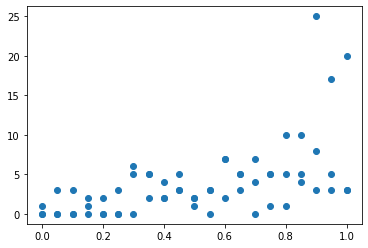

In [12]:
plt.scatter(SP, y)

# Consolidate results and see if diff-RRDR correlates with model test performance

In [19]:
result = pd.DataFrame({'Spectral Parameter':SP, 'Number': num_val, 'diff-RRDR': y})

In [27]:
final_result = pd.merge(result, rif_perf.rename(columns = {'lambda_param': 'Spectral Parameter', 'number': 'Number'}), on=['Spectral Parameter', 'Number'])
final_result = final_result.groupby(['Spectral Parameter', 'Number', 'model', 'drug']).mean().reset_index()[['Spectral Parameter', 'model', 'drug', 'Number', 'diff-RRDR', 'auc_mean']]

In [28]:
final_result

,Spectral Parameter,model,drug,Number,diff-RRDR,auc_mean
0,0.0,CNN,RIF,0,1.0,0.970836
1,0.0,ESM2,RIF,0,1.0,0.951401
2,0.0,ESM2-Finetuned,RIF,0,1.0,0.872333
3,0.0,CNN,RIF,1,0.0,0.973373
4,0.0,ESM2,RIF,1,0.0,0.954937
...,...,...,...,...,...,...
183,1.0,ESM2,RIF,1,3.0,0.826214
184,1.0,ESM2-Finetuned,RIF,1,3.0,0.718479
185,1.0,CNN,RIF,2,3.0,0.783654
186,1.0,ESM2,RIF,2,3.0,0.958816


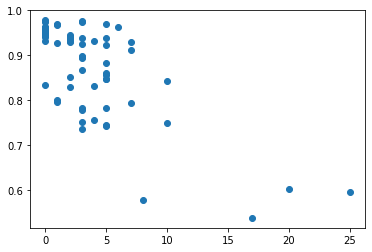

In [29]:
plt.scatter(final_result[final_result['model'] == 'CNN']['diff-RRDR'], final_result[final_result['model'] == 'CNN']['auc_mean'])

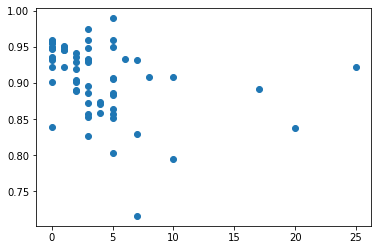

In [30]:
plt.scatter(final_result[final_result['model'] == 'ESM2']['diff-RRDR'], final_result[final_result['model'] == 'ESM2']['auc_mean'])

In [31]:
from scipy.stats import spearmanr
x_1 = final_result[final_result['model'] == 'CNN']['diff-RRDR']
y_1 = final_result[final_result['model'] == 'CNN']['auc_mean']

spearmanr(x_1, y_1)

SpearmanrResult(correlation=-0.5920216796542679, pvalue=3.2140968299202257e-07)

In [32]:
x_1 = final_result[final_result['model'] == 'ESM2']['diff-RRDR']
y_1 = final_result[final_result['model'] == 'ESM2']['auc_mean']

spearmanr(x_1, y_1)

SpearmanrResult(correlation=-0.47221182112898324, pvalue=9.333396212744513e-05)

In [35]:
final_result[(final_result['Spectral Parameter'] == 0.9)&(final_result['model'] == 'CNN')]

,Spectral Parameter,model,drug,Number,diff-RRDR,auc_mean
161,0.9,CNN,RIF,0,3.0,0.779453
164,0.9,CNN,RIF,1,25.0,0.596529
167,0.9,CNN,RIF,2,8.0,0.579589


In [33]:
1 - (0.579589/0.779453)

0.2564157171760195

In [37]:
np.std([0.579589, 0.596529, 0.779453])

0.09048865605514683

In [36]:
final_result[(final_result['Spectral Parameter'] == 0.95)&(final_result['model'] == 'CNN')]

,Spectral Parameter,model,drug,Number,diff-RRDR,auc_mean
170,0.95,CNN,RIF,0,5.0,0.782962
173,0.95,CNN,RIF,1,3.0,0.736928
176,0.95,CNN,RIF,2,17.0,0.538967


In [34]:
1 - (0.538967/0.782962)

0.31163070493842615

In [38]:
np.std([0.782962,0.736928, 0.538967])

0.10585170271133523

In [37]:
final_result[(final_result['Spectral Parameter'] == 1.0)&(final_result['model'] == 'CNN')]

,Spectral Parameter,model,drug,Number,diff-RRDR,auc_mean
179,1.0,CNN,RIF,0,20.0,0.603355
182,1.0,CNN,RIF,1,3.0,0.751384
185,1.0,CNN,RIF,2,3.0,0.783654


In [35]:
1 - (0.603355/0.783654)

0.2300747523779627

In [39]:
np.std([0.603355,0.751384, 0.783654])

0.078501002924945

In [38]:
final_result[(final_result['Spectral Parameter'] == 0.8)&(final_result['model'] == 'CNN')]

,Spectral Parameter,model,drug,Number,diff-RRDR,auc_mean
143,0.8,CNN,RIF,0,5.0,0.746384
146,0.8,CNN,RIF,1,10.0,0.750482
149,0.8,CNN,RIF,2,1.0,0.796604


In [ ]:
np.std([0.74, 0.75m 0.80])

In [39]:
final_result[(final_result['Spectral Parameter'] == 1.0)&(final_result['model'] == 'ESM2-Finetuned')]

,Spectral Parameter,model,drug,Number,diff-RRDR,auc_mean
181,1.0,ESM2-Finetuned,RIF,0,20.0,0.809722
184,1.0,ESM2-Finetuned,RIF,1,3.0,0.718479
187,1.0,ESM2-Finetuned,RIF,2,3.0,0.666934


In [40]:
final_result[(final_result['Spectral Parameter'] == 1.0)&(final_result['model'] == 'ESM2')]

,Spectral Parameter,model,drug,Number,diff-RRDR,auc_mean
180,1.0,ESM2,RIF,0,20.0,0.837158
183,1.0,ESM2,RIF,1,3.0,0.826214
186,1.0,ESM2,RIF,2,3.0,0.958816


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.


Text(0.5, 0.98, 'RIF CNN Performance versus SP and diff-RRDR')

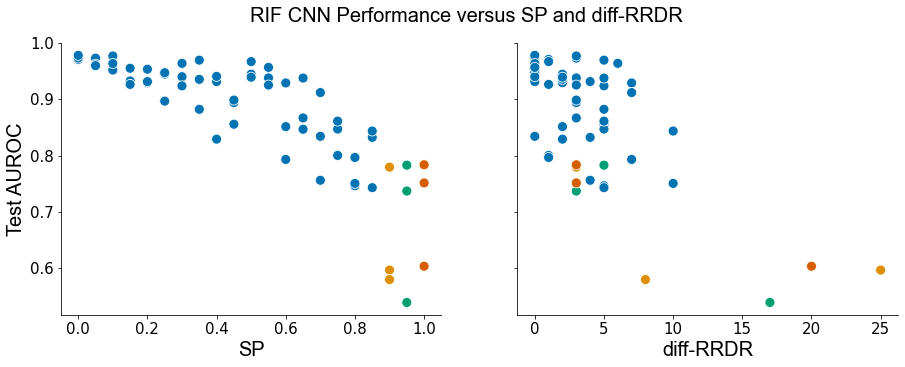

In [43]:
colors = sns.color_palette("colorblind")
palette_dict = {model: color for model, color in zip(['CNN', 'ESM2', 'ESM2-Finetuned', 'EVE',
                                                    'SeqDesign', 'Logistic Regression'],colors)}
palette_dict['Logistic Regression'] = colors[9]

f, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

def to_highlight(row):
    if row['model'] == 'CNN' and row['Spectral Parameter'] == 0.95:
        return 'SP 0.95 Split'
    elif row['model'] == 'CNN' and row['Spectral Parameter'] == 1.0:
        return 'SP 1.0 Split'
    elif row['model'] == 'CNN' and row['Spectral Parameter'] == 0.90:
        return 'SP 0.90 Split'
    else:
        return 'Other'

final_result['to_highlight'] = final_result.apply(to_highlight, axis=1)

ax_1 = sns.scatterplot(data = final_result[(final_result['model'] == 'CNN')], x = 'Spectral Parameter', y = 'auc_mean', 
                       hue='to_highlight',s=100, palette=colors,  ax=axes[0])
ax_1.set_ylabel('Test AUROC', fontsize=20, family='Arial')
ax_1.tick_params(axis='both', which='major', labelsize=15)
ax_1.set_xlabel('SP', fontsize=20, family='Arial')
ax_1.spines[['right', 'top']].set_visible(False)
ax_1.get_legend().remove()

ax_2 = sns.scatterplot(data = final_result[(final_result['model'] == 'CNN')], x = 'diff-RRDR', y = 'auc_mean', 
                       hue='to_highlight', s=100, palette=colors, ax=axes[1])
ax_2.set_ylabel('Test AUROC', fontsize=20, family='Arial')
ax_2.tick_params(axis='both', which='major', labelsize=15)
ax_2.set_xlabel('diff-RRDR', fontsize=20, family='Arial')
ax_2.spines[['right', 'top']].set_visible(False)
ax_2.get_legend().remove()

sns.set_context("paper")

f.suptitle('RIF CNN Performance versus SP and diff-RRDR',fontsize=20, family='Arial') # or plt.suptitle('Main title')
#plt.savefig('Fig4d_CNN_diff_RRDR.pdf')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.


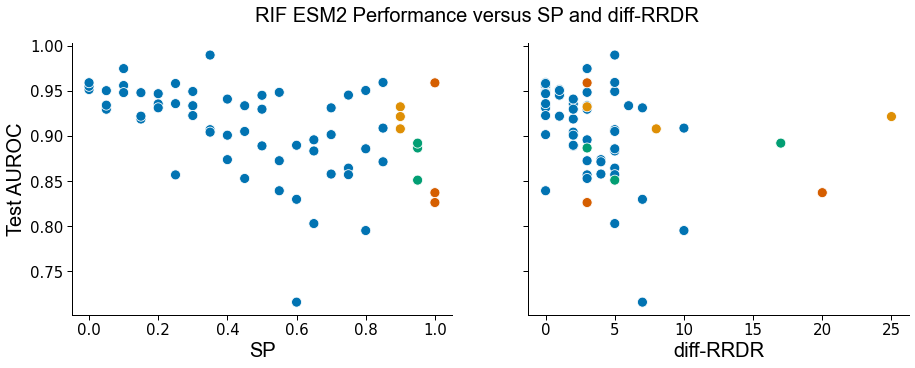

In [45]:
colors = sns.color_palette("colorblind")
palette_dict = {model: color for model, color in zip(['CNN', 'ESM2', 'ESM2-Finetuned', 'EVE',
                                                    'SeqDesign', 'Logistic Regression'],colors)}
palette_dict['Logistic Regression'] = colors[9]

f, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

def to_highlight(row):
    if row['model'] == 'ESM2' and row['Spectral Parameter'] == 0.95:
        return 'SP 0.95 Split'
    elif row['model'] == 'ESM2' and row['Spectral Parameter'] == 1.0:
        return 'SP 1.0 Split'
    elif row['model'] == 'ESM2' and row['Spectral Parameter'] == 0.90:
        return 'SP 0.90 Split'
    else:
        return 'Other'

final_result['to_highlight'] = final_result.apply(to_highlight, axis=1)

ax_1 = sns.scatterplot(data = final_result[(final_result['model'] == 'ESM2')], x = 'Spectral Parameter', y = 'auc_mean', 
                       hue='to_highlight',s=100, palette=colors,  ax=axes[0])
ax_1.set_ylabel('Test AUROC', fontsize=20, family='Arial')
ax_1.tick_params(axis='both', which='major', labelsize=15)
ax_1.set_xlabel('SP', fontsize=20, family='Arial')
ax_1.spines[['right', 'top']].set_visible(False)
ax_1.get_legend().remove()

ax_2 = sns.scatterplot(data = final_result[(final_result['model'] == 'ESM2')], x = 'diff-RRDR', y = 'auc_mean', 
                       hue='to_highlight', s=100, palette=colors, ax=axes[1])
ax_2.set_ylabel('Test AUROC', fontsize=20, family='Arial')
ax_2.tick_params(axis='both', which='major', labelsize=15)
ax_2.set_xlabel('diff-RRDR', fontsize=20, family='Arial')
ax_2.spines[['right', 'top']].set_visible(False)
ax_2.get_legend().remove()

sns.set_context("paper")

f.suptitle('RIF ESM2 Performance versus SP and diff-RRDR',fontsize=20, family='Arial') # or plt.suptitle('Main title')
plt.savefig('Fig4d_ESM2_diff_RRDR.pdf')